In [1]:
import random
import string
import timeit
import os
import numpy as np

import cupy as cp # CUDA based implementation of numpy.ndarray (GPU)
from cupy.statistics.histogram import bincount

from collections import Counter
from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_str(n):
    """ fast generation of random string """
    """ https://stackoverflow.com/questions/16308989/fastest-method-to-generate-big-random-string-with-lower-latin-letters """
    min_lc = ord(b'a')
    len_lc = 26
    ba = bytearray(os.urandom(n))
    for i, b in enumerate(ba):
        ba[i] = min_lc + b % len_lc # convert 0..255 to 97..122
    return ba.decode("utf-8")

def benchmark_range(searcher, bowl, range_, printfreq=100):
    """
    Executes a given searcher with increasing problem sizes
    """
    
    times = []
    last = 0
    
    for i in range_:
        message = get_str(i)
        start_time = timeit.default_timer()
        result = searcher.search(message)
        elapsed = timeit.default_timer() - start_time
        
        if i // printfreq > last:
            last = i // printfreq
            print("{}(N={}, M={}) returned {} in {:f} seconds".format(
            searcher.__class__.__name__, len(message), len(bowl), result, elapsed))
    
        times.append(elapsed)
        
    return times

def chunks(l, n):
    """Yield successive n-sized chunks from l.
    https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks"""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def normalize(arr):
    arr = np.array(arr)
    return (arr-min(arr))/(max(arr)-min(arr))

def countfn(x):
    return Counter(x)
        

In [76]:
class Searcher:
    """ Base class for all the searchers """

    def __init__(self, bowl):
        self.bowl = bowl

    def search(self):
        pass

class NaiveSearcher(Searcher):
    """ 
    Naive algorithm, iterates over the letters in the bowl until finding each letter in the message.
    The time complexity of this algorithm is of order O(n^2) 
    """

    def search(self, message):
        already_picked = []

        def findletter_naive(l):
            for idx,i in enumerate(self.bowl):
                if i == l and idx not in already_picked:
                    already_picked.append(idx)
                    return True
            else:
                return False

        return all(findletter_naive(i) for i in message)

class RandomSearcher(Searcher):
    """
    This is similar to the naive searcher but starting the search at random places in the bowl, if
    the bowl is big compared to the message and the letters are evenly distributed then the time complexity 
    should be of order O(n) because each letter will be found in a constant amount of time that depends 
    on the size of the alphabet.
    For bigger messages the performance will degrade to O(n^2)
    """
    
    def search(self, message):
        already_picked = {}

        def findletter_random(l):
            start = np.random.choice(len(self.bowl))
            for idx, i in enumerate(self.bowl[start: len(self.bowl)]):
                if i == l and idx+start not in already_picked:
                    already_picked[idx+start] = 1
                    return True
            for idx, i in enumerate(self.bowl[0: start]):
                if i == l and idx not in already_picked:
                    already_picked[idx] = 1
                    return True
            return False
        
        return all(findletter_random(i) for i in message)
    
class CounterSearcher(Searcher):
    """
    This algorithm starts by preprocessing the full bowl by counting how many letters of each kind the bowl
    contains. The counts are saved into a hashtable. This process is of complexity O(m). 
    After the preprocessing step each search is made in O(n) time since we have to access the hashtable 
    with the counts n times and each access to the hashtable is made in O(1) time.
    The very first search is then made in O(m + n) time.
    """
    
    def __init__(self, bowl):
        super(CounterSearcher, self).__init__(bowl)
        self.counts = Counter(self.bowl)
        
    def search(self, message):
        found = Counter()

        for letter in message:
            letters_in_bowl = self.counts[letter]
            if letters_in_bowl > found[letter]:
                found[letter] += 1
            else:
                return False

        return True
    
class CounterSearcherParalell(CounterSearcher):
    """
    This is similar to the CounterSearcher class but the preprocessing step is executed in paralell.
    Since the counting problem is perfectly paralellizable we should get a linear speedup with the addition
    of processing cores. Two cores should count the letters in half the time than one.
    """
    
    def __init__(self, bowl):
        super(CounterSearcherParalell, self).__init__(bowl)
        print("Starting process pool for {} processing cores".format(cpu_count()))
        self.pool = Pool(cpu_count())

    def search(self, message):

        chunk_size = len(self.bowl) // cpu_count()

        #map
        parts = self.pool.map(countfn, list(chunks(self.bowl, chunk_size)))
        self.counts = None
        
        #reduce
        for p in parts:
            if self.counts == None:
                self.counts = p
            else:
                self.counts += p
                
        return super(CounterSearcherParalell, self).search(message)

class CounterSearcherGPU(CounterSearcher):
    """ This is similar to the CounterSearcher class but the preprocessing is executed in a GPU. Since
    the counting problem is perfectly paralellizable this should be much faster.
    
    The calculation is done with the cupy library wich is an implementation of the numpy.ndarray class that 
    works in the GPU.
    """
    
    def __init__(self, bowl):
        nums = np.fromstring(bowl, dtype=np.uint8)
        self.counts = bincount(cp.asarray(nums))
        self.counts = {chr(idx):int(val) for idx, val in enumerate(self.counts) if idx > 96 and idx < 123}

class CounterSearcherOnline(Searcher):
    """
    This is an online version of the Counter algorithms except that it builds the counts incrementally.
    Experimentally its time complexity looks like its of order O(kn) with k being some factor that
    depends on the size of the alphabet. If the alphabet is big the probability of finding any given letter
    is smaller so we will spend a little more time searching.
,    """
    
    def search(self, message):
        
        counts = Counter()
        last_idx = 0
        found = 0
        
        for idx_message, i in enumerate(message):
            if i in counts and counts[i] > 0:
                found += 1
                counts[i] -= 1
                continue
            else:
                for idx_bowl, j in enumerate(self.bowl[last_idx:]):
                    if i == j:
                        found += 1
                        break
                    else:
                        counts[j] += 1
        
        return found == len(message)
                            
                



In [77]:
bowl = "sdfhelloasdfheeelleelehheheelhhhhz"
searcher = SearcherWithMemory(bowl)
searcher.search("hellor")

False

In [78]:
bowl = get_str(1000000)

naive = NaiveSearcher(bowl)    
naive_times = benchmark_range(naive, bowl, range(1,1000,10))

counter = CounterSearcher(bowl)
counter_times = benchmark_range(counter, bowl, range(1,1000,10))

counter_mem = SearcherWithMemory(bowl)
counter_mem_times = benchmark_range(counter_mem, bowl, range(1, 1000, 10))

counter_pre = CounterSearcherAlwaysPreprocess(bowl)
counter_pre_times = benchmark_range(counter_pre, bowl, range(1,1000,10))

counter_paralell = CounterSearcherParalell(bowl)
counter_paralell_times = benchmark_range(counter_paralell, bowl, range(1,1000,10))

counter_gpu = CounterSearcherGPU(bowl)
counter_gpu_times = benchmark_range(counter_gpu, bowl, range(1,1000,10))

random = RandomSearcher(bowl)
random_times = benchmark_range(random, bowl, range(1,1000,10))

NaiveSearcher(N=101, M=1000000) returned True in 0.000951 seconds
NaiveSearcher(N=201, M=1000000) returned True in 0.003763 seconds
NaiveSearcher(N=301, M=1000000) returned True in 0.008786 seconds
NaiveSearcher(N=401, M=1000000) returned True in 0.018537 seconds
NaiveSearcher(N=501, M=1000000) returned True in 0.030213 seconds
NaiveSearcher(N=601, M=1000000) returned True in 0.048138 seconds
NaiveSearcher(N=701, M=1000000) returned True in 0.070124 seconds
NaiveSearcher(N=801, M=1000000) returned True in 0.099792 seconds
NaiveSearcher(N=901, M=1000000) returned True in 0.135941 seconds
CounterSearcher(N=101, M=1000000) returned True in 0.000091 seconds
CounterSearcher(N=201, M=1000000) returned True in 0.000163 seconds
CounterSearcher(N=301, M=1000000) returned True in 0.000238 seconds
CounterSearcher(N=401, M=1000000) returned True in 0.000309 seconds
CounterSearcher(N=501, M=1000000) returned True in 0.000380 seconds
CounterSearcher(N=601, M=1000000) returned True in 0.000450 second

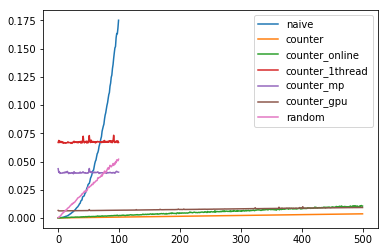

In [90]:
plt.plot(naive_times, label="naive")
plt.plot(counter_times, label="counter")
plt.plot(counter_mem_times, label="counter_online")
plt.plot(counter_pre_times, label="counter_1thread")
plt.plot(counter_paralell_times, label="counter_mp")
plt.plot(counter_gpu_times, label="counter_gpu")
plt.plot(random_times, label="random")
plt.legend(loc='upper right')

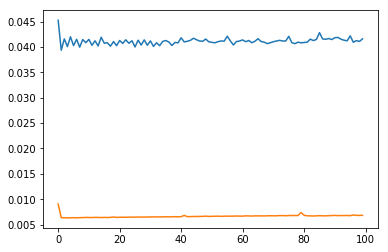

In [55]:
plt.plot(counter_paralell_times)
plt.plot(counter_gpu_times)

In [92]:
bowl = get_str(1000000)

counter_mem = SearcherWithMemory(bowl)
counter_mem_times = benchmark_range(counter_mem, bowl, range(1, 10000, 10), 1000)

counter = CounterSearcher(bowl)
counter_times = benchmark_range(counter, bowl, range(1,10000,10), 1000)

counter_gpu = CounterSearcherGPU(bowl)
counter_gpu_times = benchmark_range(counter_gpu, bowl, range(1,10000,10), 1000)

SearcherWithMemory(N=1001, M=1000000) returned True in 0.002157 seconds
SearcherWithMemory(N=2001, M=1000000) returned True in 0.004194 seconds
SearcherWithMemory(N=3001, M=1000000) returned True in 0.006761 seconds
SearcherWithMemory(N=4001, M=1000000) returned True in 0.008600 seconds
SearcherWithMemory(N=5001, M=1000000) returned True in 0.010932 seconds
SearcherWithMemory(N=6001, M=1000000) returned True in 0.013985 seconds
SearcherWithMemory(N=7001, M=1000000) returned True in 0.014807 seconds
SearcherWithMemory(N=8001, M=1000000) returned True in 0.017069 seconds
SearcherWithMemory(N=9001, M=1000000) returned True in 0.019896 seconds
CounterSearcher(N=1001, M=1000000) returned True in 0.000747 seconds
CounterSearcher(N=2001, M=1000000) returned True in 0.001470 seconds
CounterSearcher(N=3001, M=1000000) returned True in 0.002182 seconds
CounterSearcher(N=4001, M=1000000) returned True in 0.002936 seconds
CounterSearcher(N=5001, M=1000000) returned True in 0.003659 seconds
Counter

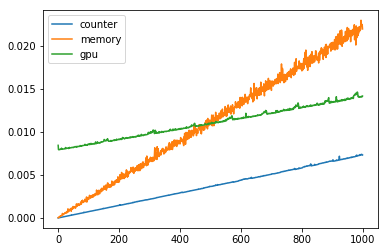

In [93]:
import matplotlib.patches as mpatches

plt.plot(counter_times, label="counter")
plt.plot(counter_mem_times, label="memory")
plt.plot(counter_gpu_times, label="gpu")
plt.legend(loc='upper left')

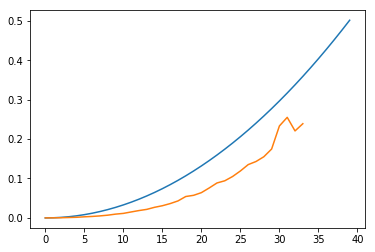

In [181]:
poly = np.polyfit([x for x, _ in enumerate(naive_times)], naive_times, 2)
poly[1] = 0
poly[2] = 0
plt.plot([np.polyval(poly, x) for x in range(40)])
plt.plot(naive_times)

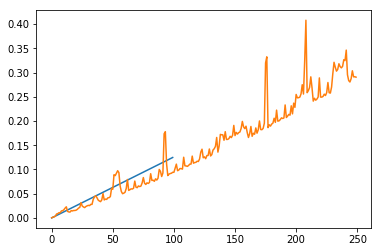

In [182]:
poly = np.polyfit([x for x, _ in enumerate(random_times)], random_times, 1)
poly[1] = 0
plt.plot([np.polyval(poly, x) for x in range(100)])
plt.plot(random_times)

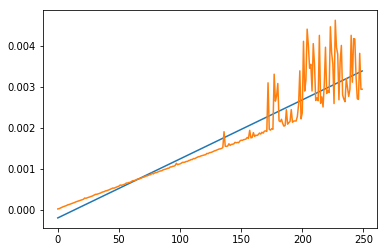

In [189]:
poly = np.polyfit([x for x, _ in enumerate(counter_times)], counter_times, 1)
plt.plot([np.polyval(poly, x) for x in range(250)])
plt.plot(counter_times)

Since the problem of counting the letters in the soup is perfectly paralell we would get a linear speedup on the number of processors used. We just have to partition de data and give each partition to each processor, then coalesce all the results. This can be done with a map-reduce operation pretty easily, here is an example that uses all the cores in the executing computer. 